In [422]:
import csv
import json
import scann
import base64
import requests
import vertexai
import pandas as pd
from io import BytesIO
from typing import Dict
from PIL import Image as img
from google.cloud import storage
import vertexai.preview.generative_models as generative_models
from vertexai.vision_models import Image, MultiModalEmbeddingModel
from vertexai.generative_models import GenerativeModel, Part, FinishReason
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

In [29]:
safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_NONE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_NONE,
}

generation_config = {
    "max_output_tokens": 8192,
    "temperature": 1,
    "top_p": 0.95,
    "response_mime_type": "application/json",
}

In [105]:
vertexai.init(project="vtxdemos", location="us-central1")
bucket = storage.Client().bucket("vtxdemos-vsearch-datasets")
model = GenerativeModel("gemini-1.5-flash-001",)
img_emb_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")
text_emb_model = TextEmbeddingModel.from_pretrained("text-embedding-004")

In [67]:
for i in bucket.list_blobs(prefix="canon/cinema/90d"):
    if i.name != "canon/cinema/90d/":
        print(i.name)

canon/cinema/90d/eos_90d_1.png
canon/cinema/90d/eos_90d_2.png
canon/cinema/90d/eos_90d_3.png
canon/cinema/90d/eos_90d_4.png


In [96]:
def create_metadata(mod: str):
    prompt = """Your task is to create metadata for a canon cameras search from the model below:,
        <rules>
        1. The output schema should have:
        - sensor_type
        - sensor_resolution
        - sensor_lens_mount
        - sensor_image_stabilization
        - sensor_video_capabilities
        - continuous_shoot_speed
        - autofocus_system
        - iso_range
        - connectivity
        2. Avoid any special characters, kanjis or anything not in english in the response.
        3. Response language: english ONLY.
        </rules>

        <output_format>

        {{sensor_type: <sensor_type>, sensor_resolution: <sensor_resolution>, sensor_lens_mount: <sensor_lens_mount>, sensor_image_stabilization: <sensor_image_stabilization>,
        sensor_video_capabilities: <sensor_video_capabilities>, continuous_shoot_speed: <continuous_shoot_speed>, autofocus_system: <autofocus_system>, iso_range: <iso_range>, 
        connectivity: <connectivity>
        }}
        </output_format>

        <model>
        {model}
        </model>
    """.format(model=mod)

    response = model.generate_content(
          [prompt],
          generation_config=generation_config,
          safety_settings=safety_settings,
      )
    try:
        return response.text
    except:
        print(reponse)
        return "There was and error with the model..."

In [125]:
def create_summary_from_image(blob_name: str):
    generation_config = {
    "max_output_tokens": 8192,
    "temperature": 1,
    "top_p": 0.95,
    }
    
    text1 = """Give me a summary/description about the image, pay special attention to the location, environment, vibe and objects."""
    image1 = Part.from_uri(
        mime_type="image/png",
        uri=f"gs://vtxdemos-vsearch-datasets/{blob_name}")
    response = model.generate_content(
        [image1, text1],
        generation_config=generation_config,
        safety_settings=safety_settings,
    )
    try:
        return response.text
    except:
        print(reponse)
        return "There was and error with the model..."

In [107]:
inputs = [TextEmbeddingInput("test", "RETRIEVAL_DOCUMENT")]
text_embeddings = text_emb_model.get_embeddings(inputs)

In [239]:
def create_embeddings(context: Dict, image: str):
    print("embeddings")
    print(context)
    text = f"""Your task is to create a human natural text from the following context including every single detail:
    <rules>
    1. In the context theres a summary coming from a description of the image, its very important to keep everything as it is without removing location, environment, vibe and objects.
    </rules>
    
    <context>:
    {context}
    </context>
    """
    generation_config = {
        "max_output_tokens": 8192,
        "temperature": 1,
        "top_p": 0.95,
    }
    
    response = model.generate_content(
        [text],
        generation_config=generation_config,
        safety_settings=safety_settings,
    )
    try:
        _re = response.text
        print(_re)
    except:
        print("There was a problem with the prompt")
        _re = "None"
        
    inputs = [TextEmbeddingInput(_re, "RETRIEVAL_DOCUMENT")]
    text_embeddings = text_emb_model.get_embeddings(inputs)[0].values
    
    img = Image(gcs_uri=f"gs://vtxdemos-vsearch-datasets/{image}")
    image_embeddings = img_emb_model.get_embeddings(
    image=img,).image_embedding
    return _re, text_embeddings, image_embeddings

In [360]:
summary_list = []
metadata_list = []
with open("canon.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        _b_name = f"canon/{row[2]}/{row[1]}"
        for i in bucket.list_blobs(prefix=_b_name):
            if i.name != _b_name+"/":
                # Creating synthetic data from models and summary/description from image using Gem 1.5
                metadata = create_metadata(row[0])
                _dic = json.loads(metadata)
                _dic["summary"] = create_summary_from_image(f"{i.name}")
                
                # Generating embeddings from text and images
                gem_metadata, text_embeddings, image_embeddings = create_embeddings(context=_dic, image=f"{i.name}")
                _dic["gem_metadata_text"] = gem_metadata
                _dic["text_embeddings"] = text_embeddings
                _dic["image_embeddings"] = image_embeddings
                _dic["image_gcs_uri"] = f"https://storage.googleapis.com/vtxdemos-vsearch-datasets/{i.name}"
                metadata_list.append(_dic)
                print("Job done...")

embeddings
{'sensor_type': 'Full Frame CMOS', 'sensor_resolution': '24.2MP', 'sensor_lens_mount': 'Canon RF', 'sensor_image_stabilization': 'In-body', 'sensor_video_capabilities': '6K RAW, 4K 120p, 4K UHD', 'continuous_shoot_speed': '30 fps', 'autofocus_system': 'Dual Pixel CMOS AF', 'iso_range': '100-102400', 'connectivity': 'Wi-Fi, Bluetooth, USB-C, Ethernet', 'summary': 'The image shows a professional camera mounted on a tripod and filming a soccer game. The camera is pointed towards a field with blurred figures of players in white jerseys, running across the green grass. The image is taken from the side of the field, giving a perspective of a videographer recording a match. The background is a stadium with blurred lights, suggesting a night game. The overall vibe is of a live sports event with focus on capturing the action.'}
This is a professional camera, probably a Canon, judging by the RF lens mount. It's got a full frame CMOS sensor, which means it's capable of capturing high-q

In [361]:
metadata_list[0]["summary"]

'The image shows a professional camera mounted on a tripod and filming a soccer game. The camera is pointed towards a field with blurred figures of players in white jerseys, running across the green grass. The image is taken from the side of the field, giving a perspective of a videographer recording a match. The background is a stadium with blurred lights, suggesting a night game. The overall vibe is of a live sports event with focus on capturing the action.'

In [362]:
df = pd.DataFrame(metadata_list)

In [365]:
df["id"] = df.index

In [371]:
df.to_csv("gs://vtxdemos-vsearch-datasets/canon_rag/data.csv",index=False)

In [368]:
df

,sensor_type,sensor_resolution,sensor_lens_mount,sensor_image_stabilization,sensor_video_capabilities,continuous_shoot_speed,autofocus_system,iso_range,connectivity,summary,gem_metadata_text,text_embeddings,image_embeddings,image_gcs_uri,id
0,Full Frame CMOS,24.2MP,Canon RF,In-body,"6K RAW, 4K 120p, 4K UHD",30 fps,Dual Pixel CMOS AF,100-102400,"Wi-Fi, Bluetooth, USB-C, Ethernet",The image shows a professional camera mounted ...,"This is a professional camera, probably a Cano...","[-0.026048528030514717, -0.016985490918159485,...","[-0.0311556105, 0.0589646399, -0.00714037335, ...",https://storage.googleapis.com/vtxdemos-vsearc...,0
1,Full Frame CMOS,24.2 MP,Canon RF,In-Body Image Stabilization,"6K RAW, 4K 120p, 4K HDR","30fps (mechanical shutter), 60fps (electronic ...",Dual Pixel CMOS AF,ISO 100-102400 (expandable to 50-204800),"Wi-Fi, Bluetooth, USB-C, Ethernet",A professional camera is set up on a tripod an...,"This is a professional camera, likely a Canon,...","[-0.03301697596907616, 0.0048211971297860146, ...","[-0.0376252942, 0.0658073202, -0.0086058164, 0...",https://storage.googleapis.com/vtxdemos-vsearc...,1
2,Full-frame CMOS,24.2 MP,Canon RF,In-body,"6K RAW, 4K 120p, 4K 60p","30 fps (mechanical shutter), 12 fps (electroni...",Dual Pixel CMOS AF,100-102400 (expandable to 204800),"Wi-Fi, Bluetooth, USB-C, HDMI",A professional film camera sits on a tripod in...,"The scene is set: a professional film camera, ...","[0.01453197468072176, -0.027086306363344193, 0...","[-0.0408496708, 0.0429093651, -0.00801905431, ...",https://storage.googleapis.com/vtxdemos-vsearc...,2
3,Full Frame CMOS,24.2MP,Canon RF,In-body Image Stabilization,"6K RAW, 4K 120p, 4K 60p, 1080p 180p","30fps (mechanical shutter), 60fps (electronic ...","Dual Pixel CMOS AF, 6072 selectable AF points",ISO 100-102400 (expandable to 50-204800),"Wi-Fi, Bluetooth, USB-C, Ethernet, HDMI",This is a photo of a professional video camera...,"This is a professional video camera, equipped ...","[-0.005402404349297285, -0.01701826974749565, ...","[-0.0380358882, 0.0583301112, -0.00289923628, ...",https://storage.googleapis.com/vtxdemos-vsearc...,3
4,Full Frame CMOS,45 MP,Canon RF,"In-body, 5-axis","8K video at 30fps, 4K video at 120fps","20fps with mechanical shutter, 12fps with elec...",Dual Pixel CMOS AF with 1053 autofocus points,ISO 100-51200 (expandable to 50-102400),"Wi-Fi, Bluetooth, USB-C, HDMI",This image is a close-up of a professional vid...,"This image shows a professional video camera, ...","[-0.012457000091671944, -0.023186523467302322,...","[-0.0202548634, 0.0398878716, 0.0155038666, 0....",https://storage.googleapis.com/vtxdemos-vsearc...,4
5,Full Frame CMOS,45MP,Canon RF,In-body Image Stabilization,"8K video recording at 24/25/30fps, 4K video re...","20fps with mechanical shutter, 20fps with elec...",Dual Pixel CMOS AF,ISO 100 - 51200 (expandable to 100-204800),"Wi-Fi, Bluetooth, USB-C, HDMI",This is a photo of a Canon camera with a lens ...,"The camera, a Canon with a sleek lens attached...","[-0.006756516173481941, 0.014059635810554028, ...","[-0.0235150214, 0.0258393735, -0.0173565075, -...",https://storage.googleapis.com/vtxdemos-vsearc...,5
6,Full Frame CMOS,45MP,Canon RF,In-body image stabilization,"8K video recording at 24fps, 4K video recordin...","20fps with mechanical shutter, 12fps with elec...",Dual Pixel CMOS AF,ISO 100-51200 (expandable to 50-102400),"Wi-Fi, Bluetooth, USB-C, HDMI",This image shows a black Canon camera laying o...,The black Canon camera rests on the red clay t...,"[-0.012832705862820148, -0.005875151604413986,...","[-0.0132461488, 0.0279267617, -0.016564874, -0...",https://storage.googleapis.com/vtxdemos-vsearc...,6
7,Full-frame CMOS,45 MP,Canon RF,In-body Image Stabilization (IBIS),"8K video recording at 24/25/30p, 4K video reco...","20 fps with mechanical shutter, 20 fps with el...",Dual Pixel CMOS AF,ISO 100-51200 (expandable to ISO 50-102400),"Wi-Fi, Bluetooth, USB-C, HDMI",A camera mounted on a tripod is positioned on .

In [269]:
df.iloc[0]["gem_metadata_text"]

'This is a full-frame, 24.2MP Canon camera with an RF lens mount. It boasts in-body image stabilization and impressive video capabilities, including 6K RAW, 4K 120p, 4K 60p, and even 1080p 180p slow-motion capture.  It can shoot up to 30fps with the mechanical shutter and 15fps with the electronic shutter.  The camera utilizes Dual Pixel CMOS AF for accurate autofocus and has an ISO range of 100-102400, expandable to 50-204800. It also offers a comprehensive suite of connectivity options, including Wi-Fi, Bluetooth, USB-C, Ethernet, and HDMI. \n\nThe image itself shows the camera mounted on a tripod, positioned on the sideline of a grass soccer field, capturing a wide shot of players in action. The focus is on the camera itself, with a blurred background suggesting the image was taken during a live game. The green field, bright lights, and blur of the players create a sense of energy and excitement, perfectly capturing the thrill of a sporting event from a unique perspective. \n'

## Testing

In [326]:
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity

def search(text_emb=None, img_emb=None, query_text=None, query_image=None, top_k=5, text_weight=0.7, image_weight=0.3):
    results = []
    
    # Text search
    if text_emb:
        inputs = [TextEmbeddingInput(query_text, "RETRIEVAL_QUERY")]
        query_embedding = np.array(text_emb_model.get_embeddings(inputs)[0].values)
        query_embedding_re = query_embedding.reshape(1, -1)
        text_similarities = cosine_similarity(query_embedding_re, np.array(text_emb).reshape(1,-1))[0]
        # text_sim = np.dot(query_embedding, np.array(text_emb))        
        return text_similarities[0]
    
    if img_emb:
        text_emb = img_emb_model.get_embeddings(contextual_text=query_text).text_embedding
        query_embedding_re = np.array(text_emb).reshape(1, -1)
        image_similarities = cosine_similarity(query_embedding_re, np.array(text_emb).reshape(1,-1))[0]
        return image_similarities[0]

In [315]:
query = "The image itself depicts this camera resting on a red clay tennis court, its lens pointed directly at the viewer.  The white lines of the court, the blurred background of a tennis net, and surrounding greenery create a vibrant and dynamic sports environment."

In [316]:
df["text_scoring"] = df.apply(lambda x: search(text_emb=x["text_embeddings"], query_text=query), axis=1)
df["image_scoring"] = df.apply(lambda x: search(img_emb=x["image_embeddings"], query_text=query), axis=1)

In [317]:
text_weight = 0.6
image_weight = 0.4

df['combined_similarity'] = df['text_scoring'] * text_weight + df['image_scoring'] * image_weight

In [321]:
# Rank
df['rank'] = df['combined_similarity'].rank(ascending=False)
df.sort_values(by='rank')

,sensor_type,sensor_resolution,sensor_lens_mount,sensor_image_stabilization,sensor_video_capabilities,continuous_shoot_speed,autofocus_system,iso_range,connectivity,summary,gem_metadata_text,text_embeddings,image_embeddings,image_gcs_uri,text_scoring,image_scoring,combined_similarity,rank
6,Full Frame CMOS,45 MP,Canon RF,In-Body Image Stabilization,"8K 30fps, 4K 120fps","20fps with mechanical shutter, 12fps with elec...",Dual Pixel CMOS AF,ISO 100-51200 (expandable to 102400),"Wi-Fi, Bluetooth, USB-C, HDMI",A black Canon camera lies on a red clay tennis...,"The scene is serene, a peaceful tableau of war...","[-0.016036657616496086, -0.006556980311870575,...","[-0.0132461488, 0.0279267654, -0.016564874, -0...",https://storage.googleapis.com/vtxdemos-vsearc...,0.763246,1.0,0.857947,1.0
0,Full Frame CMOS,24.2MP,Canon RF,In-body,"6K RAW, 4K 120p, 4K 60p, 1080p 180p","30fps (mechanical shutter), 15fps (electronic ...",Dual Pixel CMOS AF,ISO 100-102400 (expandable to ISO 50-204800),"Wi-Fi, Bluetooth, USB-C, Ethernet, HDMI",A camera mounted on a tripod is filming a socc...,"This is a full-frame, 24.2MP Canon camera with...","[-0.019074616953730583, -0.001004268298856914,...","[-0.0311556105, 0.0589646399, -0.00714037335, ...",https://storage.googleapis.com/vtxdemos-vsearc...,0.717371,1.0,0.830422,2.0
2,Full-frame CMOS,24.2MP,Canon RF,In-body Image Stabilization (IBIS),"6K RAW, 4K 120p, 4K 60p","30fps (mechanical shutter), 60fps (electronic ...",Dual Pixel CMOS AF,ISO 100-102400 (expandable to 50-204800),"Wi-Fi, Bluetooth, USB-C, Ethernet",This is a photo of a professional video camera...,"Imagine this: an empty basketball arena, the a...","[0.006548692472279072, -0.022718889638781548, ...","[-0.0408497415, 0.0429095, -0.00801906921, 0.0...",https://storage.googleapis.com/vtxdemos-vsearc...,0.704765,1.0,0.822859,3.0
19,Super 35mm CMOS,5.94K (6144 x 3456),Canon EF Mount,In-body image stabilization,"4K (UHD) up to 120p, Full HD (1080p) up to 180...",Up to 120 fps (4K),Dual Pixel CMOS AF,ISO 100-25600 (expandable to 51200),"HDMI, USB-C, Ethernet, Wi-Fi, Bluetooth",This image shows a professional camera on a tr...,The image shows a professional camera mounted ...,"[-0.016738995909690857, -0.009856920689344406,...","[-0.0194452368, 0.0534067042, -0.00855124928, ...",https://storage.googleapis.com/vtxdemos-vsearc...,0.700661,1.0,0.820397,4.0
3,Full Frame CMOS,24.2MP,Canon RF,In-body,"6K RAW, 4K 120fps, 4K UHD 60fps",30fps,Dual Pixel CMOS AF,100-102400,"Wi-Fi, Bluetooth, USB-C, Ethernet, HDMI",The image shows a professional video camera mo...,The image captures a professional video camera...,"[0.007500363513827324, -0.01569254696369171, 0...","[-0.0380357653, 0.0583297834, -0.00289930915, ...",https://storage.googleapis.com/vtxdemos-vsearc...,0.698397,1.0,0.819038,5.0
4,Full Frame CMOS,45 MP,Canon RF,In-body Image Stabilization,"8K video at 24/25/30p, 4K video up to 120p","20 fps with mechanical shutter, 20 fps with el...",Dual Pixel CMOS AF,ISO 100-51200 (expandable to 102400),"Wi-Fi, Bluetooth, USB-C, HDMI",This is a photo of a professional-looking came...,"This is a professional-looking camera setup, r...","[-0.010707493871450424, -0.007501214276999235,...","[-0.0202549323, 0.0398882069, 0.0155034987, 0....",https://storage.googleapis.com/vtxdemos-vsearc...,0.697191,1.0,0.818314,6.0
1,Full Frame CMOS,24.2MP,Canon RF,In-body,"6K RAW, 4K 120p","30fps (mechanical shutter), 60fps (electronic ...",Dual Pixel CMOS AF,ISO 100-102400 (expandable to 204800),"Wi-Fi, Bluetooth, Ethernet, USB-C",A camera on a tripod is pointed at a football/...,"The camera, a full-frame CMOS marvel with a he...","[-0.008535124361515045, -0.012100275605916977,...","[-0.0376253426, 0.065807417, -0.00860578381, 0...",https://storage.googleapis.com/vtxdemos-vsearc...,0.679728,1.0,0.807837,7.0
7,Full Frame CMOS,45MP,Canon RF,In-body image stabilization,"8K video at 24fps, 4K video at 120fps","20fps with mechanical shutter, 12fps with elec...",Dual Pixel CMOS AF,ISO 100-51

## ScaNN

In [327]:
text = np.array([r["text_embeddings"] for i, r in df.iterrows()])
img = np.array([r["image_embeddings"] for i, r in df.iterrows()])

k = int(np.sqrt(df.shape[0]))

if int(k/20) < 1:
    leave_search = 1
else:
    leave_search = int(k/20)

text_searcher = scann.scann_ops_pybind.builder(text, num_neighbors=15, distance_measure="dot_product").tree(
    num_leaves=k, num_leaves_to_search=leave_search, training_sample_size=df.shape[0]).score_brute_force(
    2).reorder(10).build()


img_searcher = scann.scann_ops_pybind.builder(img, num_neighbors=15, distance_measure="dot_product").tree(
    num_leaves=k, num_leaves_to_search=leave_search, training_sample_size=df.shape[0]).score_brute_force(
    2).reorder(10).build()

2024-06-10 20:29:02.898070: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 41
2024-06-10 20:29:02.899703: W scann/utils/gmm_utils.cc:921] Could not normalize centroid due to zero norm or empty or zero-weight partition.
2024-06-10 20:29:02.900343: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 2.194522ms.
2024-06-10 20:29:02.905636: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 41
2024-06-10 20:29:02.907851: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 2.164817ms.


# Local Testing ScaNN

In [416]:
query = "mexico"
inputs = [TextEmbeddingInput(query, "RETRIEVAL_QUERY")]
text_v1 = text_emb_model.get_embeddings(inputs)[0].values
text_v2 = img_emb_model.get_embeddings(contextual_text=query).text_embedding

neighbors_1, distances_1 = text_searcher.search(text_v1, final_num_neighbors=15)
neighbors_2, distances_2 = img_searcher.search(text_v2, final_num_neighbors=15)

def combine_and_rank(neighbors_1, distances_1, neighbors_2, distances_2, text_weight=0.7, image_weight=0.3):
    """Combines and ranks results based on weighted text and image similarities."""
    
    all_results = []  # Store results with their combined similarity scores

    shortest_length = min(len(neighbors_1), len(neighbors_2))

    for i in range(shortest_length):  # Iterate through the neighbors from both searches
        text_index = neighbors_1[i]  # Get index of text neighbor
        image_index = neighbors_2[i]  # Get index of image neighbor
        
        # Convert distances to similarities
        text_similarity = 1 - distances_1[i]
        image_similarity = 1 - distances_2[i]

        # Calculate combined similarity score
        combined_similarity = text_weight * text_similarity + image_weight * image_similarity

        all_results.append((combined_similarity, text_index, image_index))

    # Sort by combined similarity in descending order
    ranked_results = sorted(all_results, key=lambda x: x[0], reverse=False)

    return ranked_results

# Get ranked results
ranked_results = combine_and_rank(neighbors_1, distances_1, neighbors_2, distances_2)

# Output results (including original text and image data from your dataframe)
sim_list = []
index_list = []

print(ranked_results)
for similarity, text_idx, image_idx in ranked_results:
    print(similarity)
    index_list.append(text_idx)
    sim_list.append(similarity)
    if image_idx == text_idx:
        continue
    else:
        index_list.append(image_idx)
        sim_list.append(similarity)

new_df = df.iloc[index_list, :].copy()  # Make an explicit copy
new_df.loc[:, "score"] = sim_list
new_df = new_df.drop(columns=['text_embeddings', 'image_embeddings'])

[(0.6036938861012459, 39, 39), (0.7255711905658244, 8, 33), (0.739899169281125, 11, 37), (0.7436414010822772, 37, 34), (0.7454603325575591, 26, 31), (0.7505782667547464, 17, 35), (0.7524499736726284, 19, 36), (0.753825057297945, 10, 30), (0.7688134275376797, 15, 29)]
0.6036938861012459
0.7255711905658244
0.739899169281125
0.7436414010822772
0.7454603325575591
0.7505782667547464
0.7524499736726284
0.753825057297945
0.7688134275376797


In [417]:
new_df

,sensor_type,sensor_resolution,sensor_lens_mount,sensor_image_stabilization,sensor_video_capabilities,continuous_shoot_speed,autofocus_system,iso_range,connectivity,summary,gem_metadata_text,image_gcs_uri,id,score
39,CMOS,24.2MP,Canon RF,In-body,4K video at 60fps,10fps,Dual Pixel CMOS AF,ISO 100-102400 (expandable to 204800),"Wi-Fi, Bluetooth, USB-C, HDMI",This is a photo of a DSLR camera taking a phot...,"The image depicts a DSLR camera, likely a Cano...",https://storage.googleapis.com/vtxdemos-vsearc...,39,0.603694
8,CMOS,32.5 MP,Canon RF,In-body,"4K video at 60fps, 1080p video at 120fps","15fps with mechanical shutter, 30fps with elec...",Dual Pixel CMOS AF,ISO 100-32000 (expandable to 50-102400),"Wi-Fi, Bluetooth, USB-C, HDMI",A person in a green jacket with a camera in ha...,The image shows a lone figure in a green jacke...,https://storage.googleapis.com/vtxdemos-vsearc...,8,0.725571
33,CMOS,24.2 MP,Canon RF,In-body,"4K UHD (3840 x 2160) at 30/25/24p, 1080p Full ...","12 fps (mechanical shutter), 15 fps (electroni...",Dual Pixel CMOS AF,ISO 100-25600 (expandable to 51200),"Wi-Fi, Bluetooth, USB-C, HDMI",This is a photo of a camera on a tripod with t...,This is a picture of a camera mounted on a tri...,https://storage.googleapis.com/vtxdemos-vsearc...,33,0.725571
11,CMOS,20.3 MP,Canon Proprietary,Yes,"4K UHD (3840 x 2160) at 25/30fps, 1080p at 100...",10 fps,Hybrid CMOS AF,ISO 100-3200 (expandable to ISO 12800),"Wi-Fi, NFC, Bluetooth",A camera with a large lens sits in the foregro...,"The camera, a sleek black marvel with a large,...",https://storage.googleapis.com/vtxdemos-vsearc...,11,0.739899
37,CMOS,24.2 MP,Canon RF,In-body,"4K video at 60fps, 1080p at 120fps, internal r...",Up to 40 fps with electronic shutter,Dual Pixel CMOS AF,"ISO 100-102400, expandable to 204800","Wi-Fi, Bluetooth, USB-C, HDMI",The image captures a DSLR camera placed on the...,"The image depicts a DSLR camera, positioned on...",https://storage.googleapis.com/vtxdemos-vsearc...,37,0.739899
37,CMOS,24.2 MP,Canon RF,In-body,"4K video at 60fps, 1080p at 120fps, internal r...",Up to 40 fps with electronic shutter,Dual Pixel CMOS AF,"ISO 100-102400, expandable to 204800","Wi-Fi, Bluetooth, USB-C, HDMI",The image captures a DSLR camera placed on the...,"The image depicts a DSLR camera, positioned on...",https://storage.googleapis.com/vtxdemos-vsearc...,37,0.743641
34,CMOS,24.2 MP,Canon RF,In-body,"4K video at 30fps, 1080p video at 60fps",12fps,Dual Pixel CMOS AF,100-12800 (expandable to 100-51200),"Wi-Fi, Bluetooth, USB-C, HDMI",A person is taking a picture of the Christ the...,"The scene is breathtaking: a person, standing ...",https://storage.googleapis.com/vtxdemos-vsearc...,34,0.743641
26,CMOS,24.2 MP,Canon RF,In-body,"4K video at 60fps, 1080p video at 120fps","14fps with mechanical shutter, 23fps with elec...",Dual Pixel CMOS AF,100-32000 (expandable to 50-102400),"Wi-Fi, Bluetooth, USB-C, HDMI",A camera on a tripod captures the serene beaut...,"This Canon camera, equipped with a 24.2MP CMOS...",https://storage.googleapis.com/vtxdemos-vsearc...,26,0.745460
31,CMOS,24.2MP,Canon RF,In-body,"4K UHD (3840 x 2160) at 30p/25p/24p, Full HD (...",12fps,Dual Pixel CMOS AF,ISO 100-64000 (expandable to ISO 100-25600),"Wi-Fi, Bluetooth, USB-C, HDMI","A black DSLR camera sits on a stone wall, poin...",The scene is picture-perfect: a black DSLR cam...,https://storage.googleapis.com/vtxdemos-vsearc...,31,0.745460
17,Super 35mm CMOS,5.94K (6144 x 3456),Canon EF,In-body,"4K DCI/ UHD, Full HD",Up to 12fps,Dual Pixel CMOS AF,ISO 100-25600 (expandable to 100-102400),"Wi-Fi, Ethernet, HDMI, USB-C",This is a photo of a professional camera on a ...,"Imagine standing in the heart of Times Square,...",https://storage.googleapis.com/vtxdemos-vsearc...,17,0.750578


In [421]:
new_df["image_gcs_uri"].iloc[0]

'https://storage.googleapis.com/vtxdemos-vsearch-datasets/canon/life_style/r8/life_style_5.png'

In [424]:
response = requests.get(new_df["image_gcs_uri"].iloc[0])
img = img.open(BytesIO(response.content))

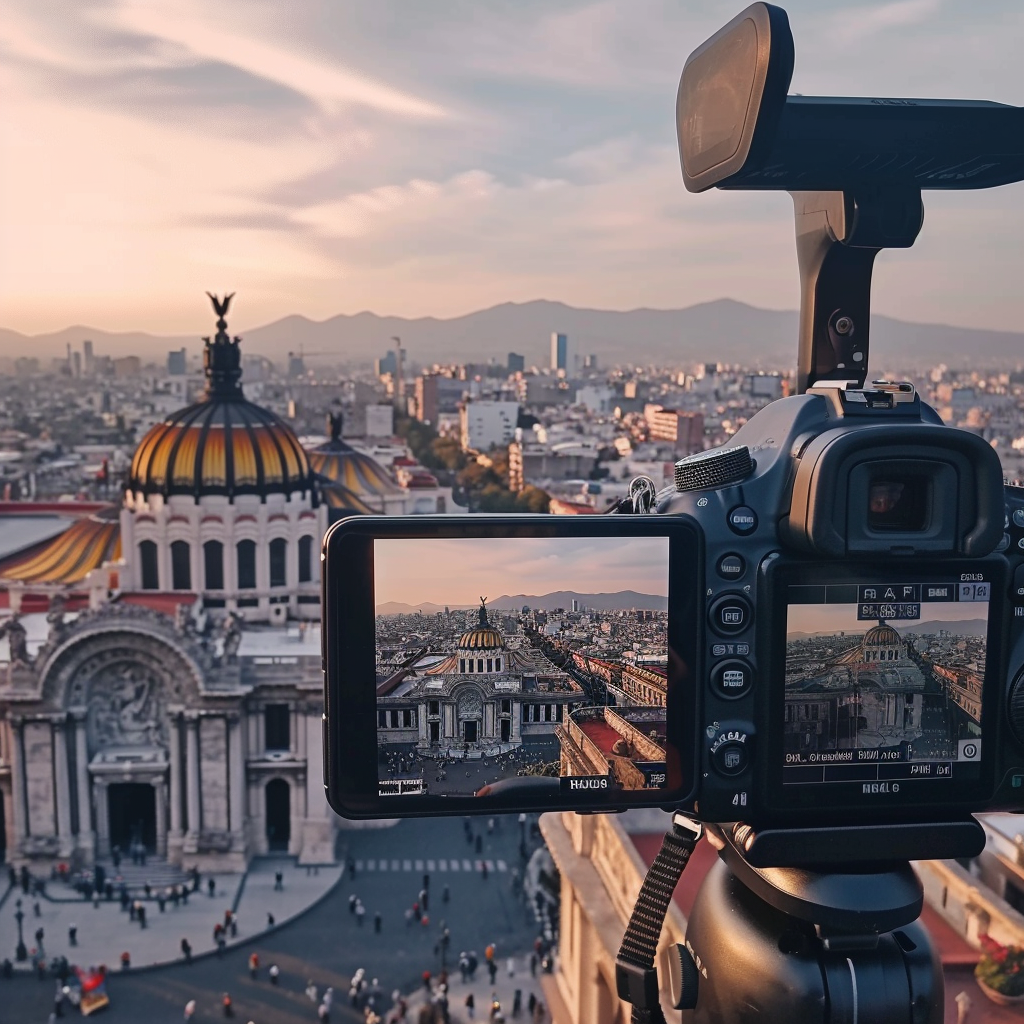

In [425]:
img